# Python Project Description.
The goal of this project is to write a Python code for a multi-zonal regression analysis of a density log data. 

The data is from a location in the US Gulf of Mexico- gmdata3.csv, with a water depth of 1500 ft, referenced from the Kelly Bushing.

The data frame consists of the measured depth (DEPTH), and density log taken at different zones in the borehole. 

There are six zones in the dataset, Zones A, B, and C have similar lithology, while zones D, F, and E have similar lithology. 

The table below provides further details about the zones. 

| Zone | Top Depth [ft]  | Bottom Depth [ft] | Density Log   |
|------|-----------------|-------------------|---------------------|
| 0    | 0               | 1000              |    1.05/gcc         |
| A    | 1001            | 2500              | Not available       |
| B    | 2501            | 5999              | Not available       |
| C    | 6000            | 10000             |    available        |
| D    | 10001           | 15000             | Not available       |
| E    | 15001           | 18000             | Not available       |
| F    | 18001           | 20878             |    available        |


## Tasks
1. Use the Amoco correlation to determine the parameters α,β for the zones.<br>
                          ρ = α + ((D-w)/3125)^γ <br>
    The density data values are in g/cm3 <br>
    ρ is the predicted density from Amoco’s correlation in g/cm3 <br>
    D is the true vertical depth in feet referenced from the Kelly Bushing <br>
    w is the water depth in feet referenced from the Kelly Bushing.

2. Use the corresponding Amoco’s parameters to predict the overburden stress profile throughout the well. 

3. Display the predicted density and available density data, as a combined log in a well log plot.




# Algorithm

1. Import necessary libraries<br>
2. Read data from csv file<br>
3. Reindex dataframe<br>
4. Replace missing values with np.nan<br>
5. Seperate data into zones<br>
6. Insert constant density for zone 0<br>
7. Fill missing value in zone C<br>
8. Initial Plot of the various zones<br>
9. Write a function for the amoco correlation<br>
10. Write a function for the over burden stress<br>
11. Get alpha and beta using zone F data<br>
12. Get alpha and beta using zone C data<br>
13. use alpha and beta values corresponding to similar lithologies to get the density values for the unknown zones<br>
14. use density values to calculate corresponding overburden stress for all depths<br>
15. Display the predicted density and available density data, as a combined log in a well log plot.<br>
16. Display the overburden stress data in a well log plot.<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
#Read csv file
df = pd.read_csv('gmdata3.csv')

#Make first row the header
df = df.rename(columns = df.iloc[0]).drop(df.index[0])
df.reset_index(inplace=True, drop=True)


#assign data type
data_types_dict = {'DEPTH': int,
                  'RHOB' : float,
                  }

df = df.astype(data_types_dict)


#replace -999.925 values
df.loc[df['RHOB'] == -999.925, 'RHOB'] = np.nan

# df.info()

In [3]:
#Grouping data
zone_0 = df.loc[(df['DEPTH'] >= 0) & (df['DEPTH'] <= 1000)]
zone_A = df.loc[(df['DEPTH'] >= 1001) & (df['DEPTH'] <= 2500)]
zone_B = df.loc[(df['DEPTH'] >= 2501) & (df['DEPTH'] <= 5999)]
zone_C = df.loc[(df['DEPTH'] >= 6000) & (df['DEPTH'] <= 10000)]
zone_D = df.loc[(df['DEPTH'] >= 10001) & (df['DEPTH'] <= 15000)]
zone_E = df.loc[(df['DEPTH'] >= 15001) & (df['DEPTH'] <= 18000)]
zone_F = df.loc[(df['DEPTH'] >= 18001) & (df['DEPTH'] <= 20878)]

zones = {'Zone 0' : zone_0, 
         'Zone A' : zone_A, 
         'Zone B' : zone_B, 
         'Zone C' : zone_C, 
         'Zone D' : zone_D, 
         'Zone E' : zone_E, 
         'Zone F' : zone_F}
zones_title = list(zones.keys())
zones_data = zones.values()

In [4]:
#for zone 0 with constant density
zone_0.loc[np.isnan(zone_0['RHOB']), 'RHOB'] = 1.05


In [5]:
zone_C.head()

,DEPTH,RHOB
6000,6000,NaN
6001,6001,1.948962
6002,6002,1.949018
6003,6003,1.949074
6004,6004,1.949130


In [6]:
# Fill missing value in zone C
imp = IterativeImputer()
x = zone_C
x = imp.fit_transform(x)
zone_C_trans = pd.DataFrame(data=x, columns=data_types_dict)
zone_C_trans['DEPTH'] = zone_C_trans['DEPTH'].astype(int)
zone_C = zone_C_trans
zone_C.head()

,DEPTH,RHOB
0,6000,1.953371
1,6001,1.948962
2,6002,1.949018
3,6003,1.949074
4,6004,1.949130


The fit method of the IterativeImputer class fits a regression model to each feature with missing values, and then uses the model to predict the missing values based on the other features in the data set.<br> The transform method replaces the missing values with the predicted values

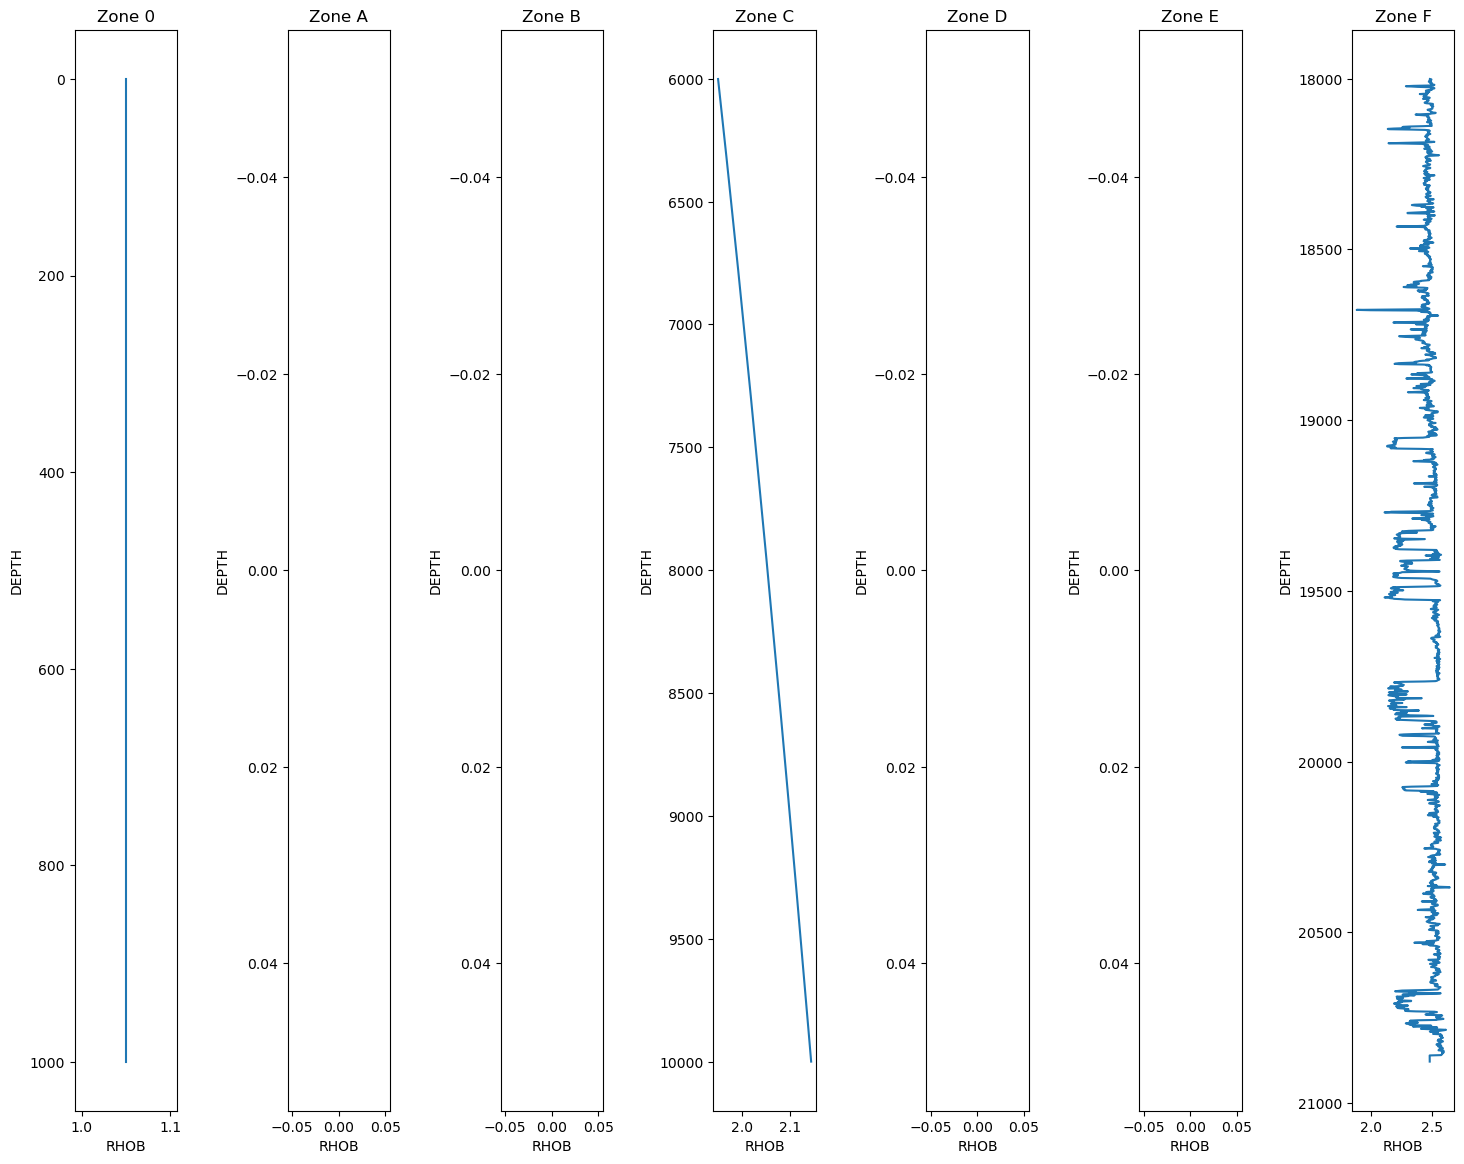

In [7]:
#plot of density vs depth

plt.figure(figsize=(15, 12))

for i, key in enumerate(zones):
        plt.subplot(1,7, i+1)
        x_data = zones.get(key)['RHOB'].values
        y_data = zones.get(key)['DEPTH'].values
        plt.plot(x_data, y_data)
        plt.gca().invert_yaxis()
        plt.title(key)
        plt.xlabel('RHOB')
        plt.ylabel('DEPTH')

plt.tight_layout(pad=2)
plt.show()


In [8]:
#amoco correlation
def amoco(depth, alpha, beta):
    density = alpha + ( ( (depth - 1000) / 3125 )**(beta) )
    return density

#overburden stress 
def overburden_stress(depth, density):
    ob = 0.43394 * density * depth
    return ob


In [9]:
#train fit for zone F
popt_F, _ = curve_fit(amoco, zone_F['DEPTH'],zone_F['RHOB'])
alpha_F, beta_F = popt_F

#train fit for zone C
popt_C, _ = curve_fit(amoco, zone_C['DEPTH'],zone_C['RHOB'])
alpha_C, beta_C = popt_C

print(popt_F, popt_C)

[0.97785148 0.22290378] [0.81027351 0.27043042]


In [10]:
# complete table for all zones
zone_A.loc[np.isnan(zone_A['RHOB']), 'RHOB'] = amoco(zone_A['DEPTH'], alpha_C, beta_C)
zone_B.loc[np.isnan(zone_B['RHOB']), 'RHOB'] = amoco(zone_B['DEPTH'], alpha_C, beta_C)
zone_D.loc[np.isnan(zone_D['RHOB']), 'RHOB'] = amoco(zone_D['DEPTH'], alpha_F, beta_F)
zone_E.loc[np.isnan(zone_E['RHOB']), 'RHOB'] = amoco(zone_E['DEPTH'], alpha_F, beta_F)

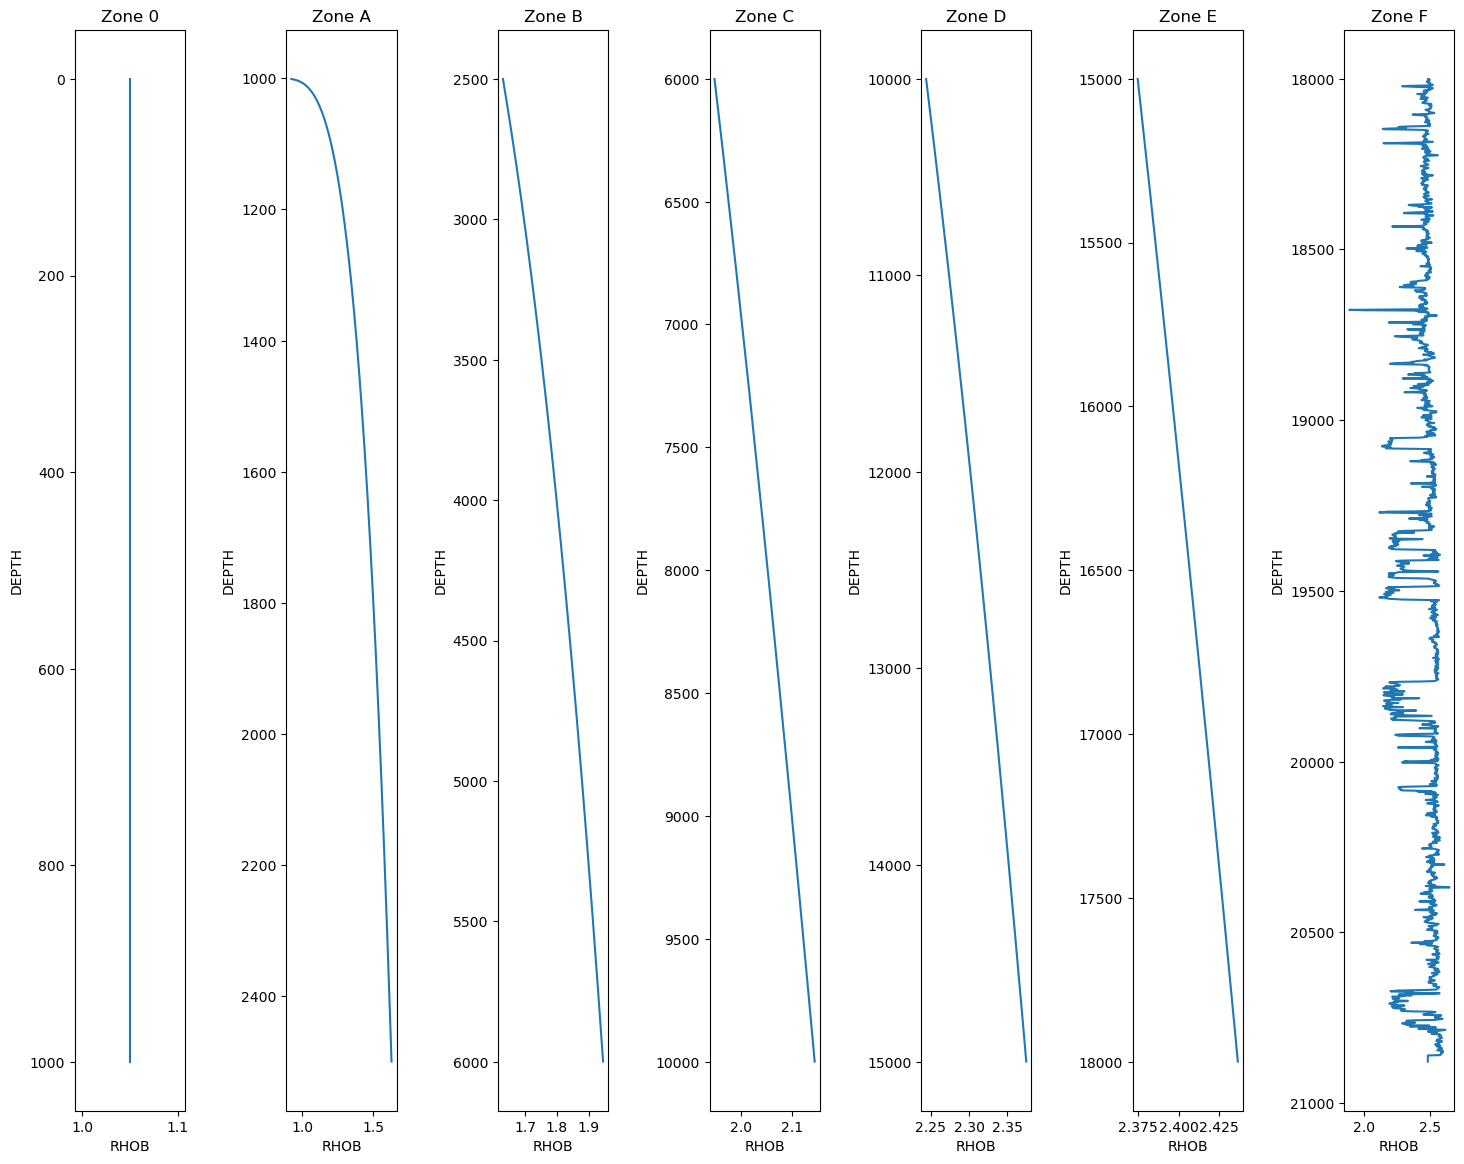

In [29]:
#plot of density vs depth

plt.figure(figsize=(15, 12))

for i, key in enumerate(zones):
        plt.subplot(1,7, i+1)
        x_data = zones.get(key)['RHOB'].values
        y_data = zones.get(key)['DEPTH'].values
        plt.plot(x_data, y_data)
        plt.gca().invert_yaxis()
        plt.title(key)
        plt.xlabel('RHOB')
        plt.ylabel('DEPTH')

plt.tight_layout(pad=2)
plt.show()


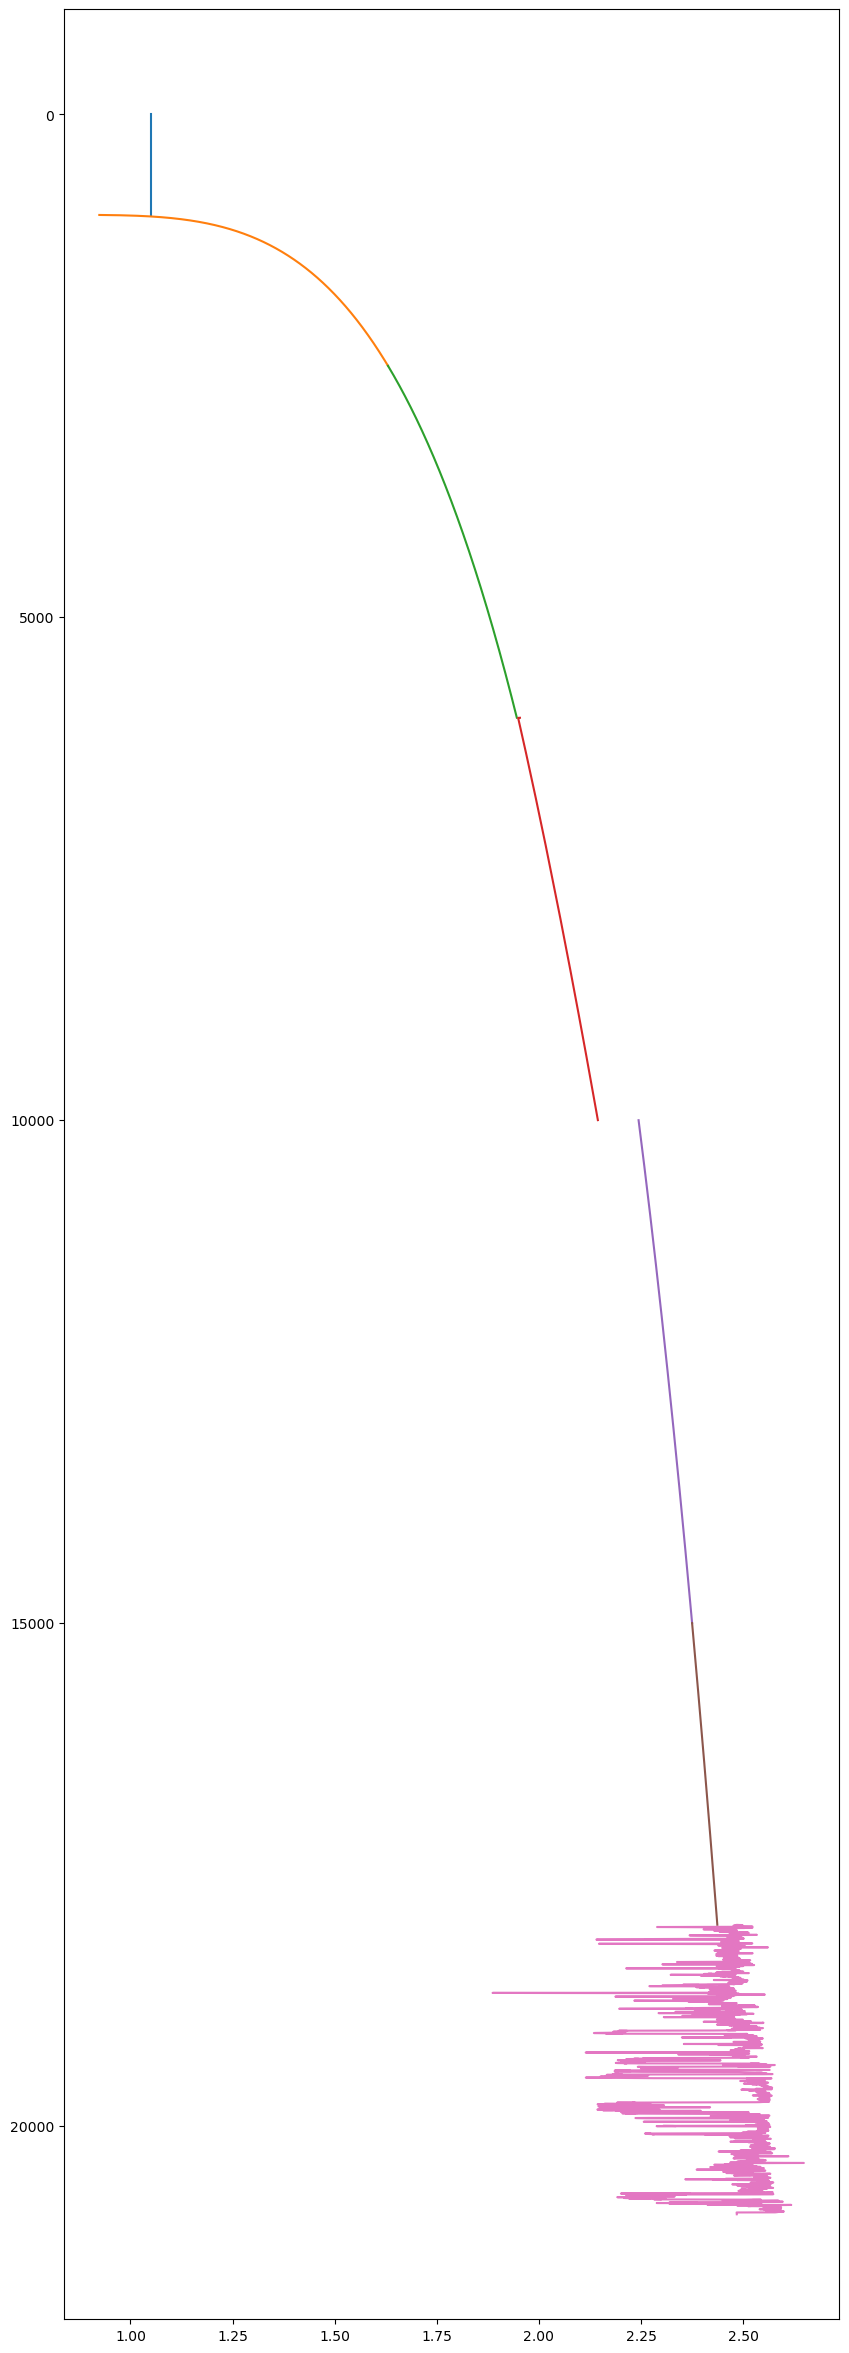

In [24]:
# Plot data for zones

# Known Zones
x_data_F = zone_F['RHOB']
y_data_F = zone_F['DEPTH']

x_data_C = zone_C['RHOB']
y_data_C = zone_C['DEPTH']

x_data_0 = zone_0['RHOB']
y_data_0 = zone_0['DEPTH']

# Predicted Zones
x_data_A = zone_A['RHOB']
y_data_A = zone_A['DEPTH']

x_data_B = zone_B['RHOB']
y_data_B = zone_B['DEPTH']

x_data_D = zone_D['RHOB']
y_data_D = zone_D['DEPTH']

x_data_E = zone_E['RHOB']
y_data_E = zone_E['DEPTH']

plt.figure(figsize=(10, 30))
plt.plot(x_data_0, y_data_0)
plt.plot(x_data_A, y_data_A)
plt.plot(x_data_B, y_data_B)
plt.plot(x_data_C, y_data_C)
plt.plot(x_data_D, y_data_D)
plt.plot(x_data_E, y_data_E)
plt.plot(x_data_F, y_data_F)

plt.gca().invert_yaxis()
plt.show()

In [25]:
# join all zones
df = pd.concat(zones_data)
df

,DEPTH,RHOB
0,0,1.050000
1,1,1.050000
2,2,1.050000
3,3,1.050000
4,4,1.050000
...,...,...
20874,20874,2.484087
20875,20875,2.484114
20876,20876,2.484141
20877,20877,2.484168


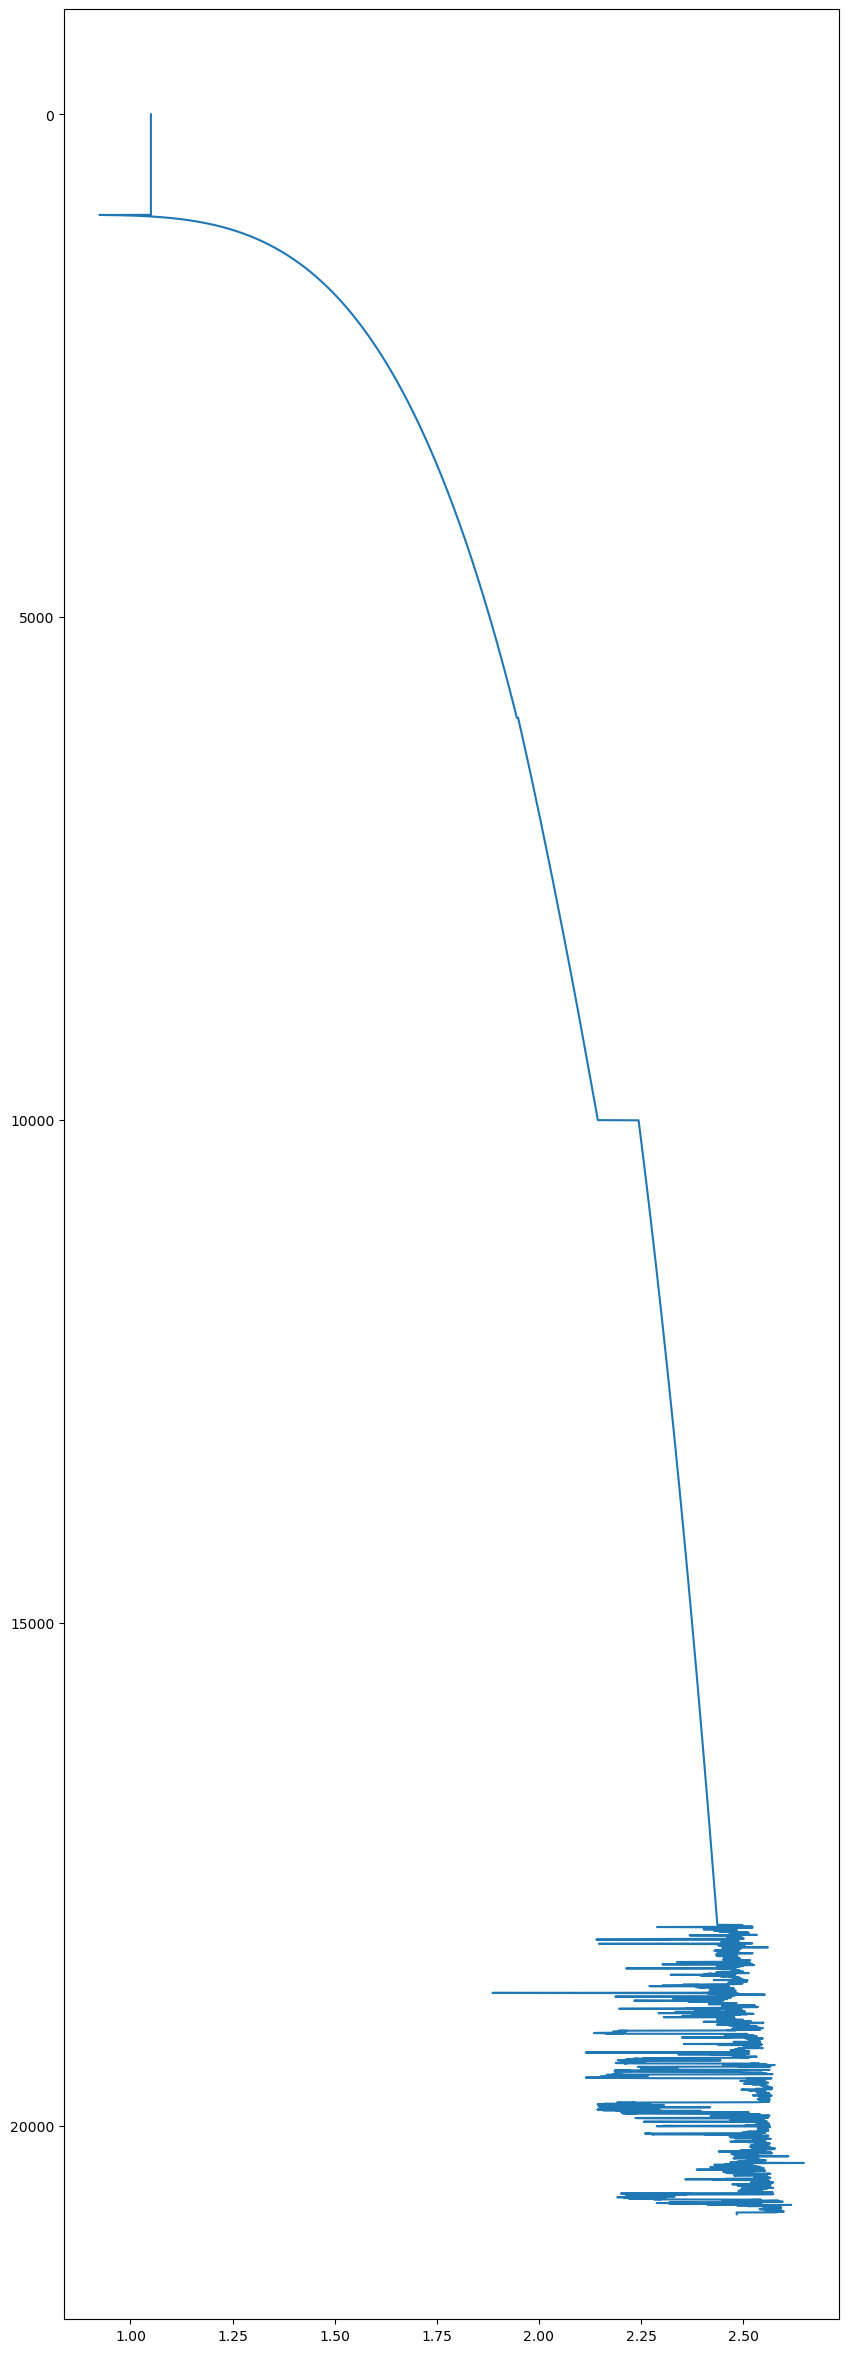

In [16]:
# display density plot

x_data = df['RHOB']
y_data = df['DEPTH']

plt.figure(figsize=(10, 30))
plt.plot(x_data, y_data, label='data')

plt.gca().invert_yaxis()
plt.show()

In [26]:
# add OB culumn for over burden stress
df['OB'] = np.nan
df

,DEPTH,RHOB,OB
0,0,1.050000,NaN
1,1,1.050000,NaN
2,2,1.050000,NaN
3,3,1.050000,NaN
4,4,1.050000,NaN
...,...,...,...
20874,20874,2.484087,NaN
20875,20875,2.484114,NaN
20876,20876,2.484141,NaN
20877,20877,2.484168,NaN


In [27]:
# calculate the overburden stress and fill OB column
df.loc[np.isnan(df['OB']), 'OB'] = overburden_stress(df['DEPTH'], df['RHOB'])
df

,DEPTH,RHOB,OB
0,0,1.050000,0.000000
1,1,1.050000,0.455637
2,2,1.050000,0.911274
3,3,1.050000,1.366911
4,4,1.050000,1.822548
...,...,...,...
20874,20874,2.484087,22501.017844
20875,20875,2.484114,22502.339843
20876,20876,2.484141,22503.664012
20877,20877,2.484168,22504.986057


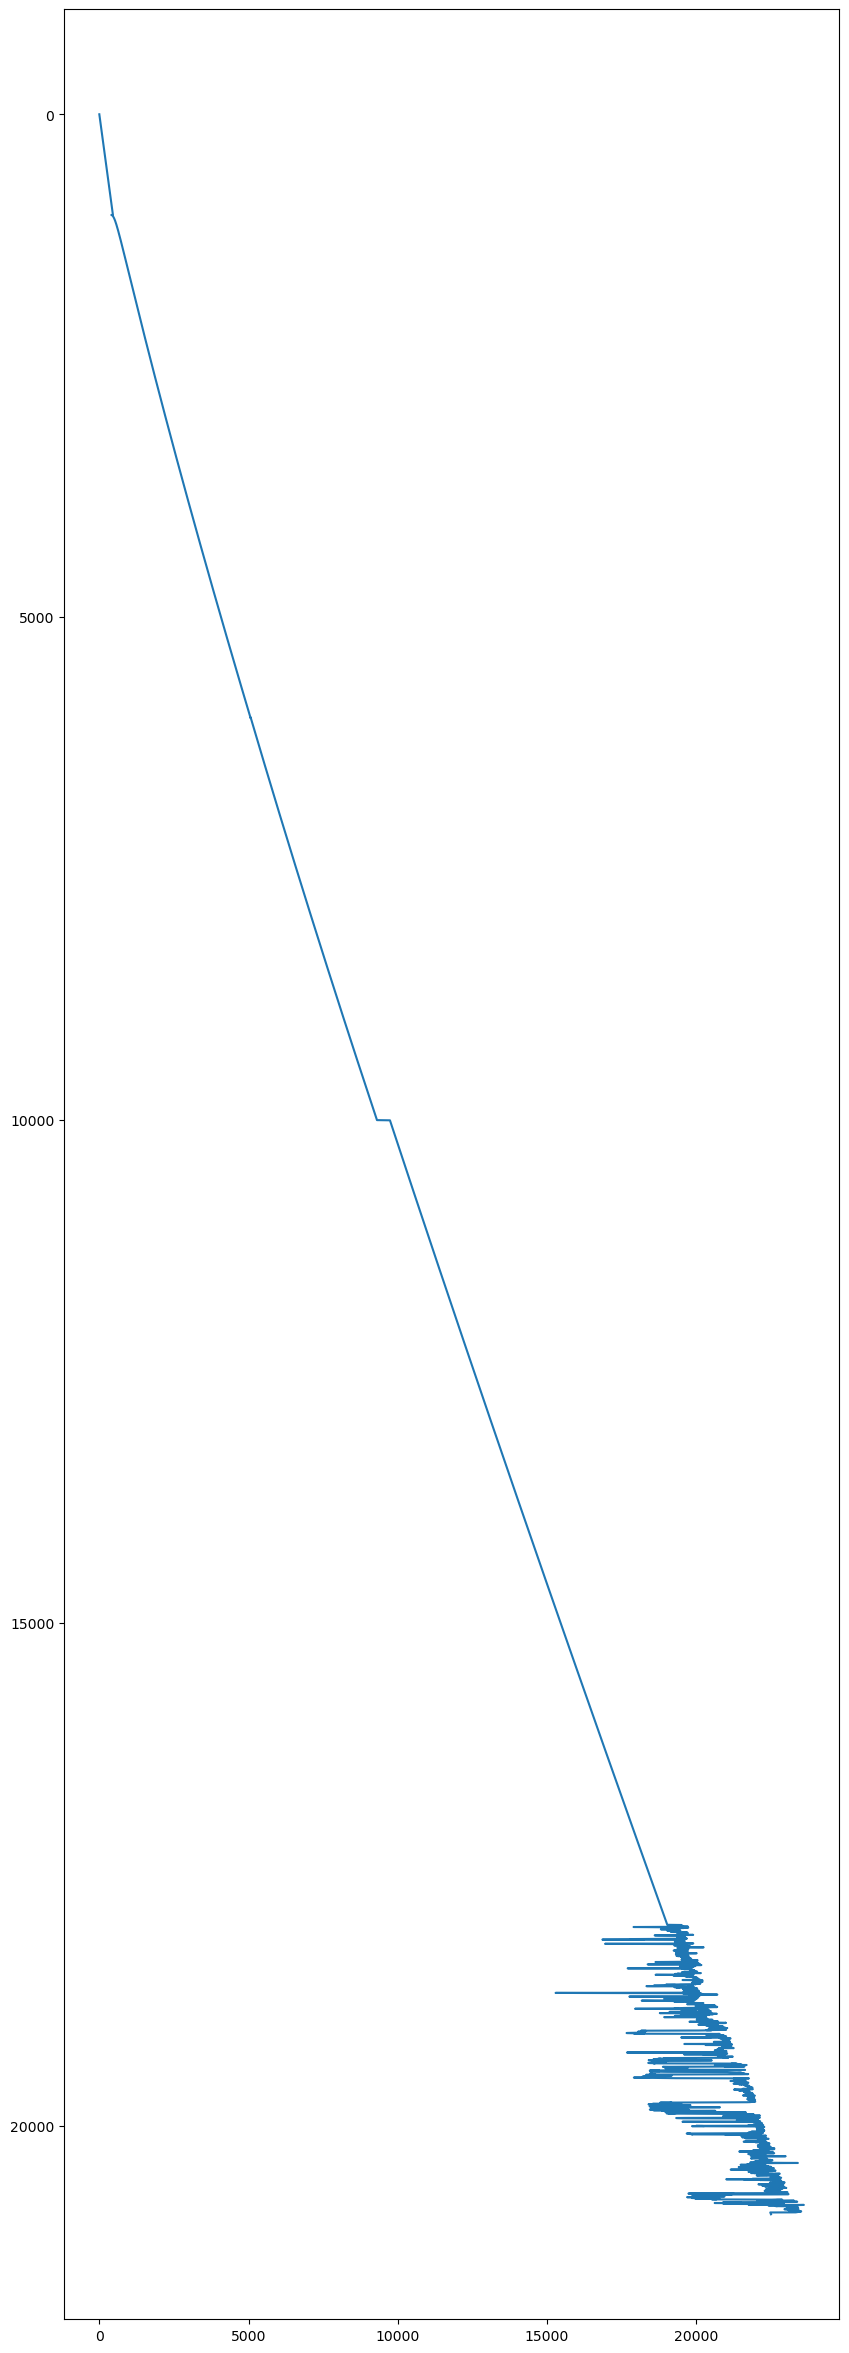

In [28]:
# display overburden stress plot

x_data = df['OB']
y_data = df['DEPTH']

plt.figure(figsize=(10, 30))
plt.plot(x_data, y_data, label='data')

plt.gca().invert_yaxis()
plt.show()